In [133]:
import matplotlib.pyplot as plt 
import scipy.misc
import numpy as np
from keras.layers import Dense, Dropout, Flatten, Input, Conv2D, Cropping2D
from keras.layers import MaxPooling2D, ZeroPadding2D, BatchNormalization, Activation, merge, GlobalAveragePooling2D
from keras.layers.merge import Add, Multiply, Average, Maximum, Concatenate, Dot
from keras.models import Model
from keras.utils.layer_utils import print_summary
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

from keras import __version__ as kv
from scipy import __version__ as sv
from matplotlib import __version__ as mv
from numpy import __version__ as nv

print kv
print sv
print mv
print nv

2.0.5
0.19.1
2.0.0
1.13.0


In [154]:
# Local files
import utils
reload(utils)
import utils2
reload(utils2)

<module 'utils2' from 'utils2.pyc'>

# Data

### Config

In [155]:
trained_model_dir = '/home/ubuntu/data/sar/experiment_crops_20170815/trained_models/4.2-as-FCN_with_visualisation_with_distance_large_crops/'

In [156]:
train_dir = '/home/ubuntu/data/sar/experiment_crops_20170815/train/240x240/'
valid_dir = '/home/ubuntu/data/sar/experiment_crops_20170815/validate/240x240/'

In [157]:
input_shape = (240, 240, 1)
num_classes = 3

### Convert tifs to png (only need to run once)

In [158]:
utils.tif2png(src_dir=train_dir+"oil_and_gas_infrastructure/", dest_dir=train_dir+"oil_and_gas_infrastructure/")
utils.tif2png(src_dir=train_dir+"other/", dest_dir=train_dir+"other/")
utils.tif2png(src_dir=train_dir+"turbine/", dest_dir=train_dir+"turbine/")

/home/ubuntu/data/sar/experiment_crops_20170815/train/240x240/oil_and_gas_infrastructure/ 1000
/home/ubuntu/data/sar/experiment_crops_20170815/train/240x240/oil_and_gas_infrastructure/ 1000 1000
/home/ubuntu/data/sar/experiment_crops_20170815/train/240x240/other/ 1000
/home/ubuntu/data/sar/experiment_crops_20170815/train/240x240/other/ 1000 1000
/home/ubuntu/data/sar/experiment_crops_20170815/train/240x240/turbine/ 2000
/home/ubuntu/data/sar/experiment_crops_20170815/train/240x240/turbine/ 2000 2000


Done in 1.0-mph_as_kd-baseline-simple_CNN_from_scratch.ipynb

In [159]:
utils.tif2png(src_dir=valid_dir+"oil_and_gas_infrastructure/", dest_dir=valid_dir+"oil_and_gas_infrastructure/")
utils.tif2png(src_dir=valid_dir+"other/", dest_dir=valid_dir+"other/")
utils.tif2png(src_dir=valid_dir+"turbine/", dest_dir=valid_dir+"turbine/")

/home/ubuntu/data/sar/experiment_crops_20170815/validate/240x240/oil_and_gas_infrastructure/ 250
/home/ubuntu/data/sar/experiment_crops_20170815/validate/240x240/oil_and_gas_infrastructure/ 250 250
/home/ubuntu/data/sar/experiment_crops_20170815/validate/240x240/other/ 250
/home/ubuntu/data/sar/experiment_crops_20170815/validate/240x240/other/ 250 250
/home/ubuntu/data/sar/experiment_crops_20170815/validate/240x240/turbine/ 500
/home/ubuntu/data/sar/experiment_crops_20170815/validate/240x240/turbine/ 500 500


In [168]:
train_crops, train_filename, train_feature, train_class, \
valid_crops, valid_filename, valid_feature, valid_class = utils.add_dist2land_experiment_crops_20170815()

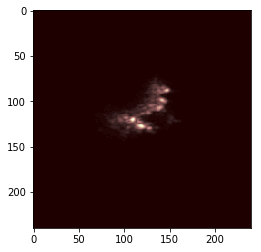

In [169]:
plt.imshow( train_crops[0], cmap='pink')
plt.show()

In [170]:
print "training crops:", len(train_crops)
print "training features:", len(train_feature)
print "validation crops:", len(valid_filename)
print "validation features:", len(valid_feature)
print type(train_crops), type(train_crops[0]), train_crops[0].shape

training crops: 1973
training features: 1973
validation crops: 498
validation features: 498
<type 'list'> <type 'numpy.ndarray'> (240, 240)


In [171]:
# large crop problems training data set
# 
bad_crop_count = 0

for idx, element in enumerate(train_crops):
    if element.shape != (240,240):
        print idx, element.shape, train_class[idx], train_filename[idx]
        bad_crop_count += 1
        
print bad_crop_count

0


For reference the bad 240 x 240 crops were (all other class):

1526 (240, 215) S1A_IW_GRDH_1SDV_20170502T174100_20170502T174125_016406_01B2B3_900F_subset2_11.png
1606 (240, 155) S1A_IW_GRDH_1SDV_20170806T174108_20170806T174133_017806_01DD7A_EF7A_subset6_10.png
1630 (180, 240) S1A_IW_GRDH_1SDV_20170607T174104_20170607T174129_016931_01C2D4_E8F6_subset3_24.png
1654 (240, 153) S1A_IW_GRDH_1SDV_20170719T040549_20170719T040614_017535_01D533_D6AB_subset1_2.png
1675 (240, 188) S1A_IW_GRDH_1SDV_20170424T110608_20170424T110637_016285_01AF0A_B2F9_subset7_0.png
1688 (217, 240) S1A_IW_GRDH_1SDV_20170713T174106_20170713T174131_017456_01D2CA_7339_subset1_4.png
1713 (145, 240) S1A_IW_GRDH_1SDV_20170607T174104_20170607T174129_016931_01C2D4_E8F6_subset7_35.png
1715 (182, 240) S1A_IW_GRDH_1SDV_20170607T174104_20170607T174129_016931_01C2D4_E8F6_subset8_11.png
1717 (240, 190) S1A_IW_GRDH_1SDV_20170424T110608_20170424T110637_016285_01AF0A_B2F9_subset2_2.png
1725 (240, 192) S1A_IW_GRDH_1SDV_20170713T174106_20170713T174131_017456_01D2CA_7339_subset2_9.png
1784 (240, 195) S1B_IW_GRDH_1SDV_20170420T015703_20170420T015732_005238_0092B9_0365_subset7_1.png
1817 (240, 147) S1A_IW_GRDH_1SDV_20170502T174100_20170502T174125_016406_01B2B3_900F_subset7_0.png
1831 (230, 153) S1A_IW_GRDH_1SDV_20170713T174106_20170713T174131_017456_01D2CA_7339_subset8_3.png
1926 (240, 181) S1A_IW_GRDH_1SDV_20170717T110613_20170717T110642_017510_01D46D_05C7_subset7_1.png
1941 (240, 159) S1A_IW_GRDH_1SDV_20170526T174103_20170526T174128_016756_01BD64_D7CD_subset9_10.png
1961 (207, 240) S1B_IW_GRDH_1SDV_20170615T061318_20170615T061343_006057_00AA34_F4E6_subset2_0.png
1966 (170, 240) S1A_IW_GRDH_1SDV_20170502T174100_20170502T174125_016406_01B2B3_900F_subset3_19.png
1972 (213, 240) S1A_IW_GRDH_1SDV_20170713T174106_20170713T174131_017456_01D2CA_7339_subset8_20.png
1988 (240, 155) S1A_IW_GRDH_1SDV_20170719T040549_20170719T040614_017535_01D533_D6AB_subset6_34.png
1989 (240, 157) S1B_IW_GRDH_1SDV_20170721T061820_20170721T061845_006582_00B93A_B503_subset2_3.png
20

In [172]:
# large crop problems validation data set
# 
bad_crop_count = 0

for idx, element in enumerate(valid_crops):
    if element.shape != (240,240):
        print idx, element.shape, valid_class[idx], valid_filename[idx]
        bad_crop_count += 1
        
print bad_crop_count

0


For reference the bad 240 x 240 crops were (all other class):
383 (161, 240) [0, 0, 1] S1A_IW_GRDH_1SDV_20170607T174104_20170607T174129_016931_01C2D4_E8F6_subset7_34.png

In [174]:
# Reshape for keras format
np_train_class = np.array(train_class)
np_train_filename = np.array(train_filename)
np_train_crops = np.array(train_crops)
np_train_feature = np.array(train_feature)

np_valid_class = np.array(valid_class)
np_valid_filename = np.array(valid_filename)
np_valid_crops = np.array(valid_crops)
np_valid_feature = np.array(valid_feature)

np_train_crops = np.expand_dims(np_train_crops, axis=3)
np_train_feature = np.expand_dims(np_train_feature, axis=1)

np_valid_crops = np.expand_dims(np_valid_crops, axis=3)
np_valid_feature = np.expand_dims(np_valid_feature, axis=1)

In [175]:
print np_train_crops.shape
print np_train_feature.shape
print np_train_class.shape
print test.shape
print np_valid_crops.shape
print np_valid_feature.shape
print np_valid_class.shape

(1973, 240, 240, 1)
(1973, 1)
(1973, 3)
(473520, 240)
(498, 240, 240, 1)
(498, 1)
(498, 3)


In [176]:
np.array(train_crops).shape


(1973, 240, 240)

# Experiments

## Baseline FCN (using https://github.com/asmith26/courses/blob/master/deeplearning1/nbs/lesson7.ipynb)

In [177]:
p = 0

classifier_input = Input(shape=input_shape)
dist2land_input = Input(shape=(1,), name='dist2land_input')


x = Conv2D(32, (3, 3), activation='relu', padding='same')(classifier_input)
x = MaxPooling2D()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D()(x)   # REMOVED MAX POOLING FOR VISUALISATION
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)

# # Following based on https://github.com/asmith26/courses/blob/master/deeplearning1/nbs/lesson7.ipynb
x = BatchNormalization(axis=-1)(x)
x = Conv2D(64,(3,3), activation='relu', padding='same')(x)
x = BatchNormalization(axis=-1)(x)
x = MaxPooling2D()(x)   # REMOVED MAX POOLING FOR VISUALISATION
x = Conv2D(64,(3,3), activation='relu', padding='same')(x)
x = BatchNormalization(axis=-1)(x)
x = MaxPooling2D()(x)   # REMOVED MAX POOLING FOR VISUALISATION

x = merge([x, dist2land_input], 'concat')

x = Conv2D(3,(3,3), padding='same')(x)
x = Dropout(p)(x)
x = GlobalAveragePooling2D()(x)
x = Activation('softmax')(x)


model_with_distance = Model(outputs=x, inputs=classifier_input)
model_with_distance.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:22: UserWarning:

The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.

/usr/local/lib/python2.7/dist-packages/keras/legacy/layers.py:460: UserWarning:

The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.



ValueError: "concat" mode can only merge layers with matching output shapes except for the concat axis. Layer shapes: [(None, 15, 15, 64), (None, 1)]

In [178]:
p = 0

classifier_input = Input(shape=input_shape)
dist2land_input = Input(shape=(1,))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(classifier_input)
x = MaxPooling2D()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D()(x)   # REMOVED MAX POOLING FOR VISUALISATION
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)

# # Following based on https://github.com/asmith26/courses/blob/master/deeplearning1/nbs/lesson7.ipynb
x = BatchNormalization(axis=-1)(x)
x = Conv2D(64,(3,3), activation='relu', padding='same')(x)
x = BatchNormalization(axis=-1)(x)
x = MaxPooling2D()(x)   # REMOVED MAX POOLING FOR VISUALISATION
x = Conv2D(64,(3,3), activation='relu', padding='same')(x)
x = BatchNormalization(axis=-1)(x)
x = MaxPooling2D()(x)   # REMOVED MAX POOLING FOR VISUALISATION
x = Conv2D(3,(3,3), padding='same')(x)
x = Dropout(p)(x)
x = GlobalAveragePooling2D()(x)
m = Add()([dist2land_input, x])
out = Activation('softmax')(m)


model_with_distance = Model(inputs=[classifier_input, dist2land_input], outputs=out)
model_with_distance.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [179]:
model_with_distance.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 240, 240, 1)   0                                            
____________________________________________________________________________________________________
conv2d_6 (Conv2D)                (None, 240, 240, 32)  320         input_2[0][0]                    
____________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)   (None, 120, 120, 32)  0           conv2d_6[0][0]                   
____________________________________________________________________________________________________
conv2d_7 (Conv2D)                (None, 120, 120, 64)  18496       max_pooling2d_5[0][0]            
___________________________________________________________________________________________

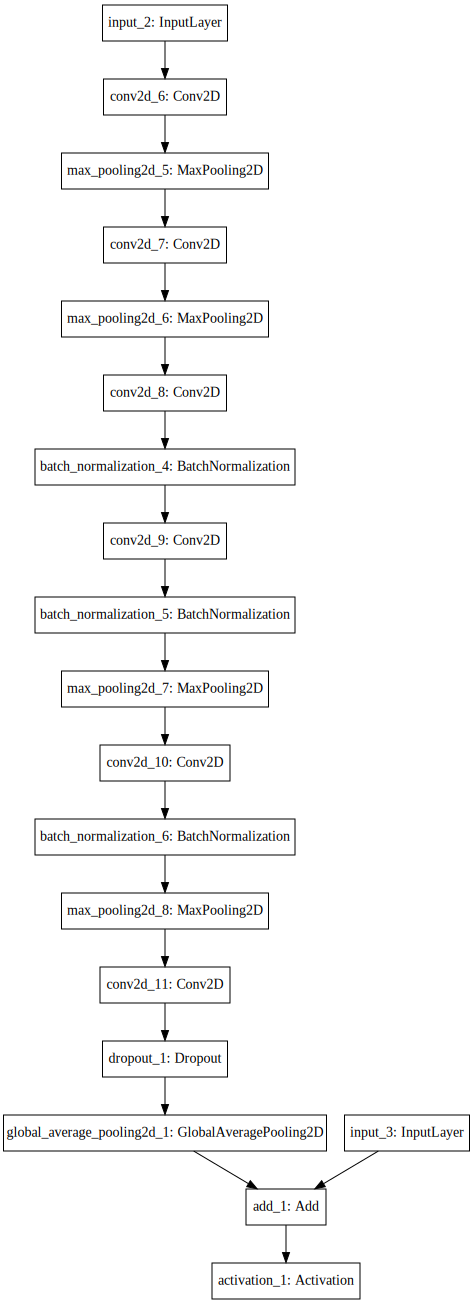

In [180]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model_with_distance).create(prog='dot', format='svg'))

In [181]:
lr = 0.001
K.set_value(model_with_distance.optimizer.lr, lr)

model_with_distance.fit([np_train_crops, np_train_feature], np_train_class,
          batch_size=32,
          epochs=10,
          validation_data=([np_valid_crops, np_valid_feature], np_valid_class))

Train on 1973 samples, validate on 498 samples
Epoch 1/10
1973/1973 [==============================] - 360s - loss: 0.5148 - acc: 0.7927 - val_loss: 0.5382 - val_acc: 0.8293
Epoch 2/10
1973/1973 [==============================] - 360s - loss: 0.2400 - acc: 0.9103 - val_loss: 0.5492 - val_acc: 0.7932
Epoch 3/10
1973/1973 [==============================] - 360s - loss: 0.1937 - acc: 0.9295 - val_loss: 0.3681 - val_acc: 0.8675
Epoch 4/10
1973/1973 [==============================] - 361s - loss: 0.1480 - acc: 0.9473 - val_loss: 0.3283 - val_acc: 0.8936
Epoch 5/10
1973/1973 [==============================] - 360s - loss: 0.1280 - acc: 0.9488 - val_loss: 0.2730 - val_acc: 0.9217
Epoch 6/10
1973/1973 [==============================] - 360s - loss: 0.1152 - acc: 0.9559 - val_loss: 1.1954 - val_acc: 0.4940
Epoch 7/10
1973/1973 [==============================] - 360s - loss: 0.0870 - acc: 0.9686 - val_loss: 0.2679 - val_acc: 0.9116
Epoch 8/10
1973/1973 [==============================] - 360s - l

In [182]:
lr = 0.0001
K.set_value(model_with_distance.optimizer.lr, lr)

model_with_distance.fit([np_train_crops, np_train_feature], np_train_class,
          batch_size=32,
          epochs=5,
          validation_data=([np_valid_crops, np_valid_feature], np_valid_class))

Train on 1973 samples, validate on 498 samples
Epoch 1/5
1973/1973 [==============================] - 360s - loss: 0.0329 - acc: 0.9883 - val_loss: 0.1615 - val_acc: 0.9458
Epoch 2/5
1973/1973 [==============================] - 363s - loss: 0.0208 - acc: 0.9929 - val_loss: 0.1590 - val_acc: 0.9518
Epoch 3/5
1973/1973 [==============================] - 363s - loss: 0.0139 - acc: 0.9980 - val_loss: 0.1504 - val_acc: 0.9518
Epoch 4/5
1973/1973 [==============================] - 363s - loss: 0.0123 - acc: 0.9970 - val_loss: 0.1518 - val_acc: 0.9478
Epoch 5/5
1973/1973 [==============================] - 363s - loss: 0.0089 - acc: 0.9990 - val_loss: 0.1528 - val_acc: 0.9458


In [183]:
lr = 0.0001
K.set_value(model_with_distance.optimizer.lr, lr)

model_with_distance.fit([np_train_crops, np_train_feature], np_train_class,
          batch_size=32,
          epochs=3,
          validation_data=([np_valid_crops, np_valid_feature], np_valid_class))

Train on 1973 samples, validate on 498 samples
Epoch 1/3
1973/1973 [==============================] - 363s - loss: 0.0082 - acc: 0.9980 - val_loss: 0.1582 - val_acc: 0.9538
Epoch 2/3
1973/1973 [==============================] - 363s - loss: 0.0059 - acc: 0.9990 - val_loss: 0.1484 - val_acc: 0.9478
Epoch 3/3
1973/1973 [==============================] - 363s - loss: 0.0051 - acc: 0.9995 - val_loss: 0.1686 - val_acc: 0.9498


In [184]:
lr = 0.00001
K.set_value(model_with_distance.optimizer.lr, lr)

model_with_distance.fit([np_train_crops, np_train_feature], np_train_class,
          batch_size=32,
          epochs=3,
          validation_data=([np_valid_crops, np_valid_feature], np_valid_class))

Train on 1973 samples, validate on 498 samples
Epoch 1/3
1973/1973 [==============================] - 363s - loss: 0.0030 - acc: 1.0000 - val_loss: 0.1640 - val_acc: 0.9478
Epoch 2/3
1973/1973 [==============================] - 363s - loss: 0.0020 - acc: 1.0000 - val_loss: 0.1636 - val_acc: 0.9538
Epoch 3/3
1973/1973 [==============================] - 363s - loss: 0.0037 - acc: 1.0000 - val_loss: 0.1624 - val_acc: 0.9518


No better than without distance.

In [185]:
# mph dropout change

p = 0.3

classifier_input = Input(shape=input_shape)
dist2land_input = Input(shape=(1,))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(classifier_input)
x = MaxPooling2D()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D()(x)   # REMOVED MAX POOLING FOR VISUALISATION
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)

# # Following based on https://github.com/asmith26/courses/blob/master/deeplearning1/nbs/lesson7.ipynb
x = BatchNormalization(axis=-1)(x)
x = Conv2D(64,(3,3), activation='relu', padding='same')(x)
x = BatchNormalization(axis=-1)(x)
x = MaxPooling2D()(x)   # REMOVED MAX POOLING FOR VISUALISATION
x = Conv2D(64,(3,3), activation='relu', padding='same')(x)
x = BatchNormalization(axis=-1)(x)
x = MaxPooling2D()(x)   # REMOVED MAX POOLING FOR VISUALISATION
x = Conv2D(3,(3,3), padding='same')(x)
x = Dropout(p)(x)
x = GlobalAveragePooling2D()(x)
m = Add()([dist2land_input, x])
out = Activation('softmax')(m)


model_with_distance = Model(inputs=[classifier_input, dist2land_input], outputs=out)
model_with_distance.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [188]:
lr = 0.001
K.set_value(model_with_distance.optimizer.lr, lr)

model_with_distance.fit([np_train_crops, np_train_feature], np_train_class,
          batch_size=32,
          epochs=10,
          validation_data=([np_valid_crops, np_valid_feature], np_valid_class))

Train on 1973 samples, validate on 498 samples
Epoch 1/10
1973/1973 [==============================] - 362s - loss: 0.4040 - acc: 0.8490 - val_loss: 0.5614 - val_acc: 0.7912
Epoch 2/10
1973/1973 [==============================] - 368s - loss: 0.2957 - acc: 0.8880 - val_loss: 0.5169 - val_acc: 0.8112
Epoch 3/10
1973/1973 [==============================] - 370s - loss: 0.2114 - acc: 0.9169 - val_loss: 0.4058 - val_acc: 0.8554
Epoch 4/10
1973/1973 [==============================] - 363s - loss: 0.1878 - acc: 0.9290 - val_loss: 0.3357 - val_acc: 0.8835
Epoch 5/10
1973/1973 [==============================] - 363s - loss: 0.1664 - acc: 0.9346 - val_loss: 0.2082 - val_acc: 0.9297
Epoch 6/10
1973/1973 [==============================] - 364s - loss: 0.1423 - acc: 0.9518 - val_loss: 0.2494 - val_acc: 0.9217
Epoch 7/10
1973/1973 [==============================] - 362s - loss: 0.1253 - acc: 0.9574 - val_loss: 0.1941 - val_acc: 0.9378
Epoch 8/10
1973/1973 [==============================] - 363s - l

In [189]:
lr = 0.0001
K.set_value(model_with_distance.optimizer.lr, lr)

model_with_distance.fit([np_train_crops, np_train_feature], np_train_class,
          batch_size=32,
          epochs=5,
          validation_data=([np_valid_crops, np_valid_feature], np_valid_class))

Train on 1973 samples, validate on 498 samples
Epoch 1/5
1973/1973 [==============================] - 360s - loss: 0.0558 - acc: 0.9792 - val_loss: 0.1339 - val_acc: 0.9518
Epoch 2/5
1973/1973 [==============================] - 361s - loss: 0.0299 - acc: 0.9919 - val_loss: 0.1309 - val_acc: 0.9498
Epoch 3/5
1973/1973 [==============================] - 361s - loss: 0.0239 - acc: 0.9939 - val_loss: 0.1241 - val_acc: 0.9598
Epoch 4/5
1973/1973 [==============================] - 361s - loss: 0.0192 - acc: 0.9949 - val_loss: 0.1397 - val_acc: 0.9498
Epoch 5/5
1973/1973 [==============================] - 361s - loss: 0.0164 - acc: 0.9965 - val_loss: 0.1207 - val_acc: 0.9578
